In [16]:
import pandas as pd
import numpy as np
from configuration import model_configuration
#from PhasedLSTM import PhasedLSTM

from keras.layers import LSTM, Dense, Input, Flatten, RepeatVector, Reshape
from keras.models import Model
from configuration import model_configuration

In [17]:
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

In [19]:
def windowing(a, window_lenght=model_configuration.input_size, step_ahead=model_configuration.step_ahead):
    #a=a.tolist()
    window_number = (len(a) - step_ahead - window_lenght)
    x_sample = []
    y_sample = []
    for i in range(window_number):
        x_sample.append(a[i:(i + window_lenght), :-1])
        y_sample.append(a[i + window_lenght + step_ahead, -1])

    x_sample = np.asarray(x_sample)
    y_sample = np.asarray(y_sample)

    x_sample = x_sample.reshape((-1, window_lenght, a.shape[1]-1))
    y_sample = y_sample.reshape((-1, 1))

    return x_sample, y_sample

In [20]:


def getLSTM_model(input_shape=model_configuration.input_size):
    
    encoded_dim=8
    input_dim=18
    
    inputs = Input(shape=(input_shape, input_dim))
    encoded = LSTM(encoded_dim*2, activation='tanh')(inputs)
    encoded = RepeatVector(input_shape/2)(encoded)
    encoded = LSTM(encoded_dim, activation='tanh')(encoded)
    encoded = RepeatVector(input_shape/4)(encoded)
    encoded = LSTM(encoded_dim/2, activation='tanh')(encoded)
    decoded = RepeatVector(input_shape)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)
    decoded = Flatten()(decoded)
    decoded = Dense(input_shape*input_dim)(decoded)
    #decoded = Reshape((input_shape, input_dim))(decoded)
    decoded = Dense(1)(decoded)
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    return encoder, autoencoder

def getPhasedLSTM_model(input_shape=model_configuration.input_size):
    
    encoded_dim=4
    input_dim=18
    
    inputs = Input(shape=(input_shape, input_dim))
    encoded = LSTM(encoded_dim*2, activation='tanh')(inputs)
    decoded = Dense(input_shape*input_dim)(encoded)
    decoded = Dense(1)(decoded)
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    return encoder, autoencoder

In [21]:
import seaborn as sns
input_shape=128
step_ahead=1

In [22]:
full_dataFrame=pd.DataFrame()

for i in range(1,7):
    dx = pd.read_csv('linup/Test {}/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
    sx = pd.read_csv('linup/Test {}/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
    length=np.max([len(dx), len(sx)])
    sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
    target = np.linspace(0,1,length)
    sequence['target']=target
    sequence.head()
    full_dataFrame=full_dataFrame.append(sequence, ignore_index=True)
    del full_dataFrame['d0']
    del full_dataFrame['s0']
    full_dataFrame=full_dataFrame.fillna(0)
    
    

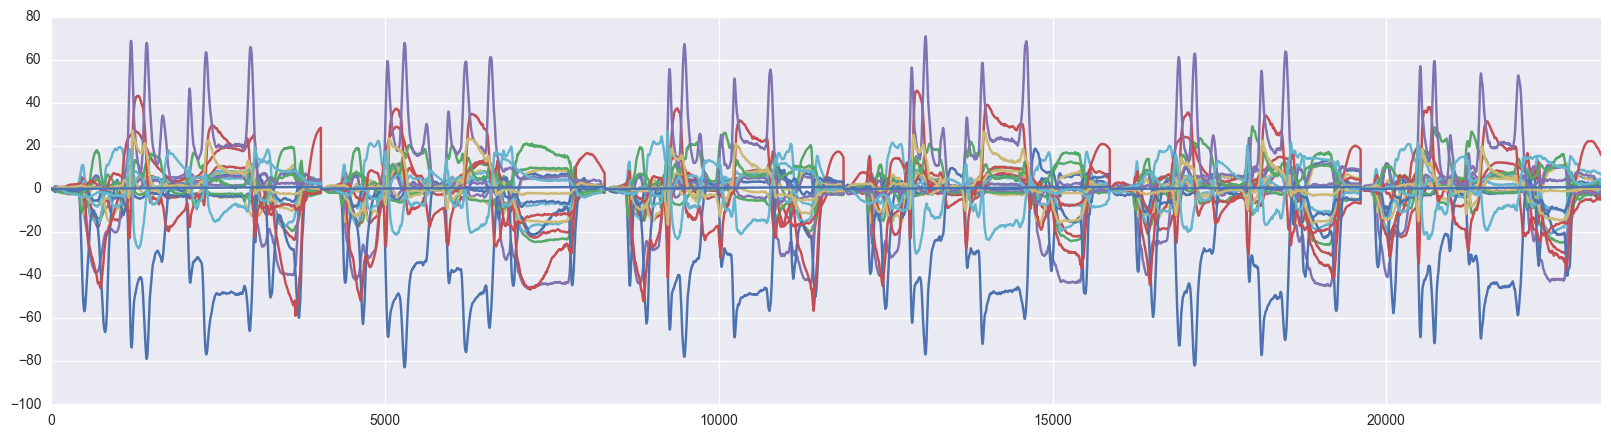

In [23]:
data_plot=full_dataFrame
data_plot.plot(figsize=(20,5), legend=False)

In [24]:
x = full_dataFrame
target = full_dataFrame.loc[:,'target']

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))

In [26]:
x_scaled=scaler.fit_transform(x)

In [27]:
x_,y = windowing(x_scaled, window_lenght=input_shape,step_ahead=step_ahead)

In [28]:
encoder, autoencoder = getPhasedLSTM_model(input_shape=128)

In [29]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
history=autoencoder.fit(x_,y,nb_epoch=50,verbose=1, batch_size=128)

Epoch 1/50
23089/23089 [==============================] - 78s - loss: 0.1788      

In [63]:
x_pred=autoencoder.predict(x_)
x_latent = encoder.predict(x_)
x_real=np.reshape(x_[:,input_shape-1,0], (-1,1))

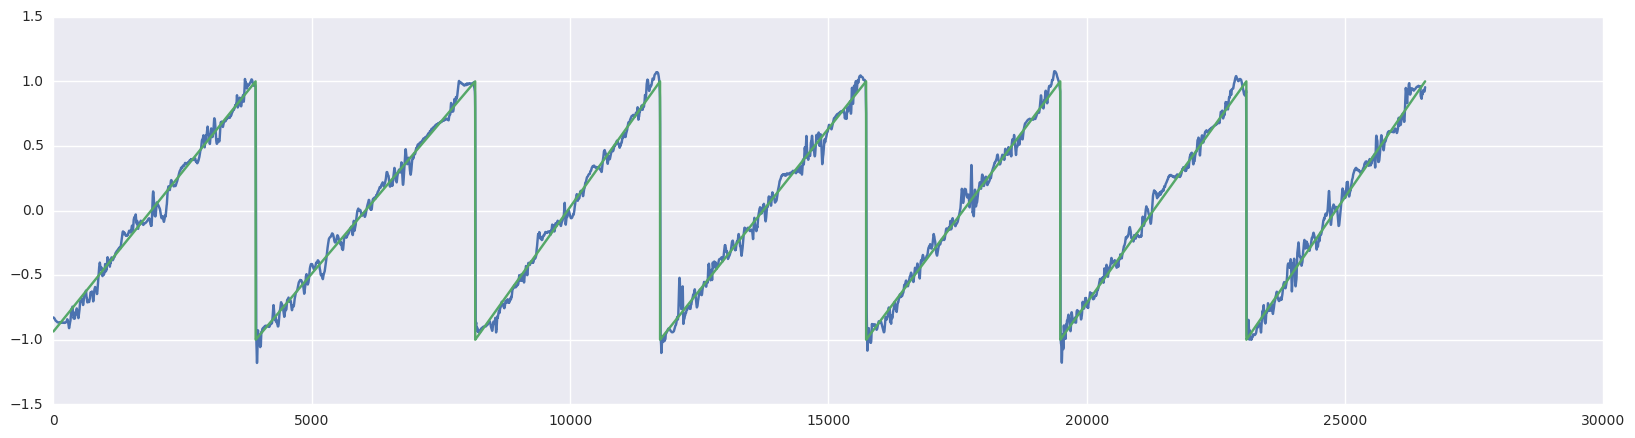

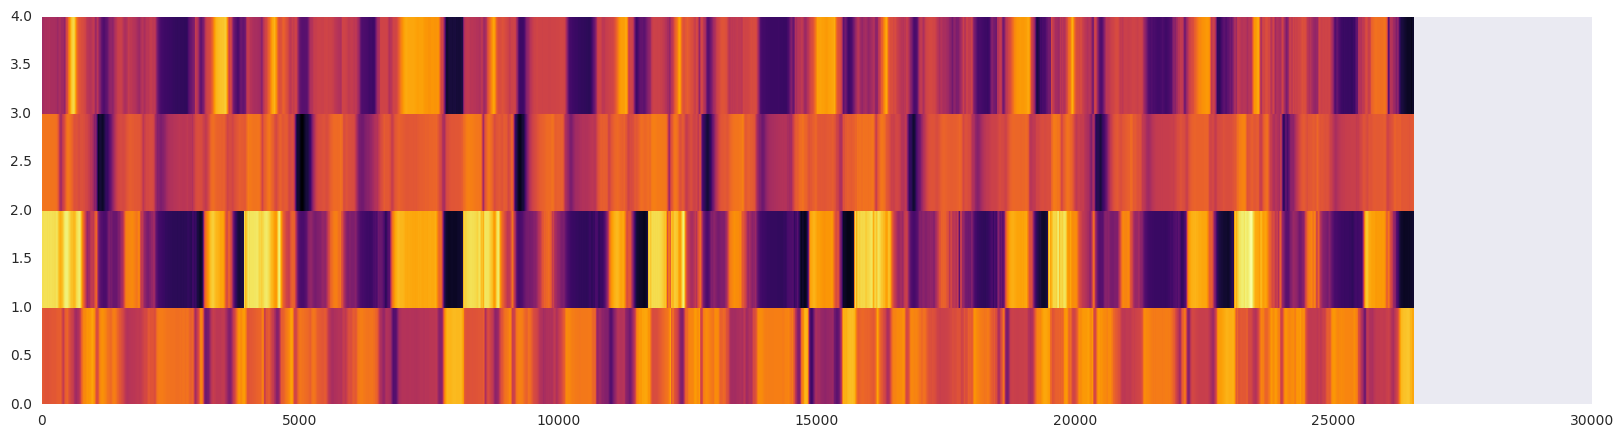

In [64]:
plt.figure(figsize=(20,5))
start=0
size=40000
plt.plot(x_pred[start:start+size,:])
plt.plot(y[start:start+size,:])
#plt.plot(x_pred[start:start+size,input_shape-8,1]-x_[start:start+size,0,0])
plt.figure(figsize=(20,5))
plt.pcolor(x_latent[start:start+size,:4].T, cmap=plt.cm.inferno)

In [82]:
start=0
size=35000
step_ahead=model_configuration.step_ahead
error=(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1])
error_ewma = pd.DataFrame(error).ewm(com=100).std(bias=False)*3
sigma3=abs(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1]).std()*3
absolute_error=0.2
print(sigma3)
error.shape

0.901066080956


(33608, 1)

In [83]:
graph=np.asarray(x.iloc[:,:-1])

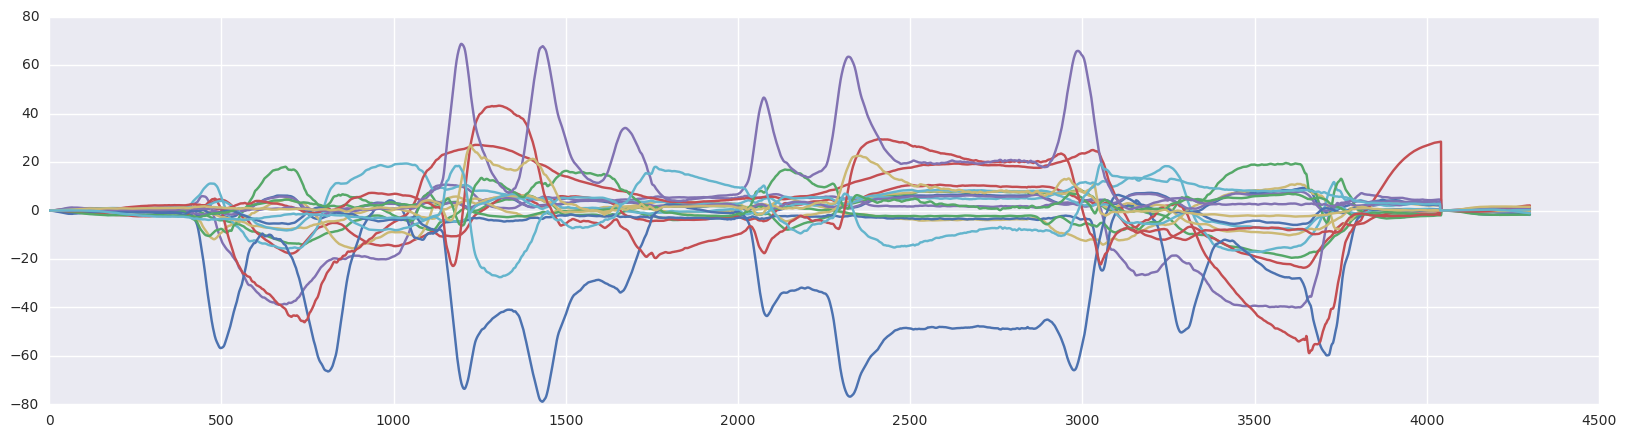

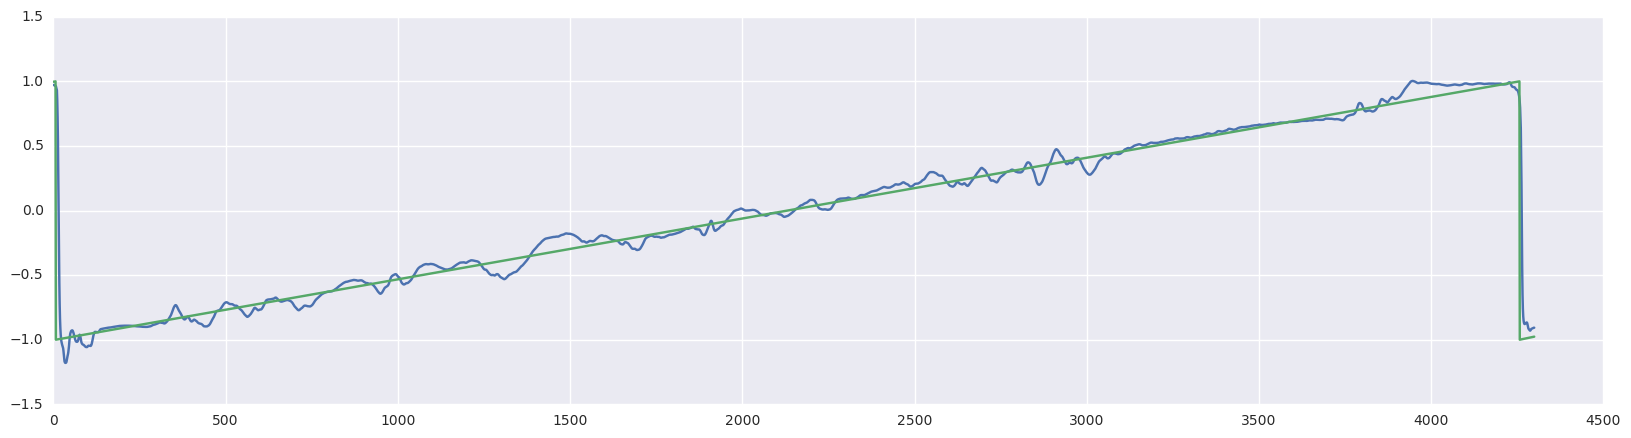

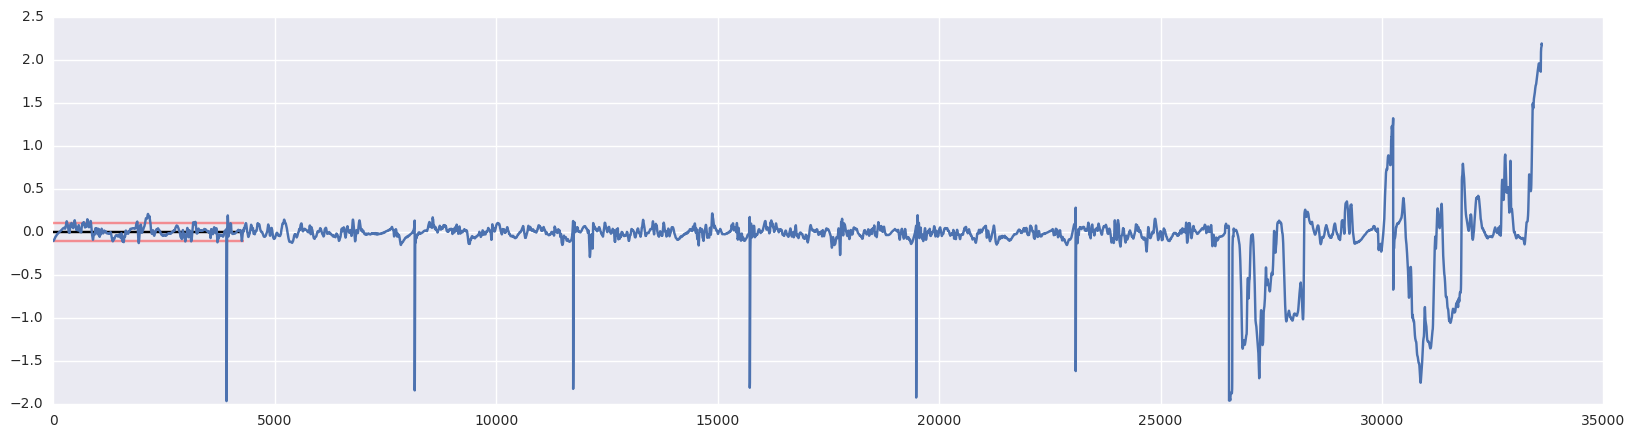

In [120]:
plt.figure(figsize=(20,5))
start=3900
size=4300
plt.plot(graph[:size])
anomalies=np.select([error>=sigma3, error<=-sigma3,error>=-sigma3, error<=sigma3],[1,1,0, 0],0)
anomalies=np.select([error_ewma>=absolute_error, error_ewma<=-absolute_error,error_ewma>=-absolute_error, error_ewma<=absolute_error],[1,1,0, 0],0)
plt.figure(figsize=(20,5))
plt.plot(x_pred[start+step_ahead+1:start+step_ahead+size+1,0])
plt.plot(y[start+step_ahead+1:start+step_ahead+size+1])
plt.figure(figsize=(20,5))
plt.plot(error)
plt.hlines(0.2/2. ,0, size,alpha=0.4, color='r')
plt.hlines(-0.2/2. ,0, size,alpha=0.4, color='r')
plt.hlines(0 ,0, size)
#nfft=128
#plt.plot((error_ewma))
#plt.bar(np.arange(len(anomalies)), anomalies, alpha=.1)
#plt.figure(figsize=(20,5))
#plt.specgram(error[:,0], NFFT=nfft, noverlap=nfft-1, sides='twosided', xextent=(nfft/2.0,len(error)-nfft/2.0))


In [101]:
error_dataFrame=pd.DataFrame()

for i in range(9,11):
    dx = pd.read_csv('linup/Test {}_errato/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
    sx = pd.read_csv('linup/Test {}_errato/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
    length=np.max([len(dx), len(sx)])
    sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
    target = np.linspace(0,1,length)
    sequence['target']=target
    error_dataFrame=error_dataFrame.append(sequence, ignore_index=True)
    del error_dataFrame['d0']
    del error_dataFrame['s0']
    error_dataFrame=error_dataFrame.fillna(0)

In [102]:
x = full_dataFrame.append(error_dataFrame)
graph=np.asarray(x.iloc[:,:-1])
target = full_dataFrame.loc[:,'target']
x.shape

(33743, 19)

In [103]:
x_scaled=scaler.transform(x)

In [104]:
x_,y = windowing(x_scaled, window_lenght=input_shape,step_ahead=step_ahead)

In [105]:
x_pred=autoencoder.predict(x_)
x_latent = encoder.predict(x_)
x_real=np.reshape(x_[:,input_shape-1,0], (-1,1))

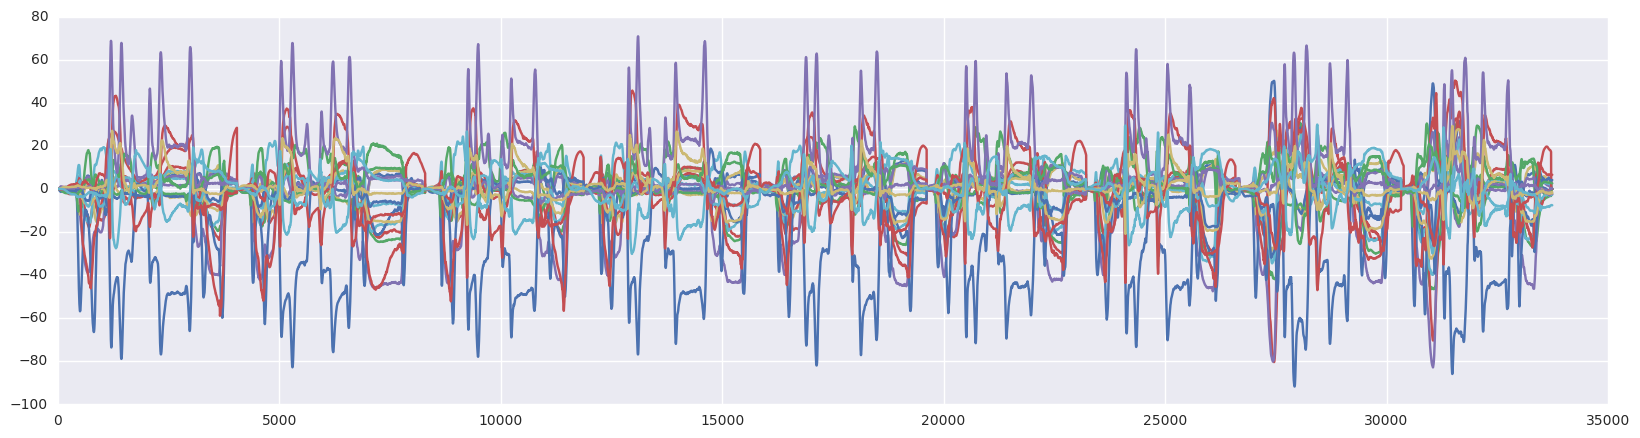

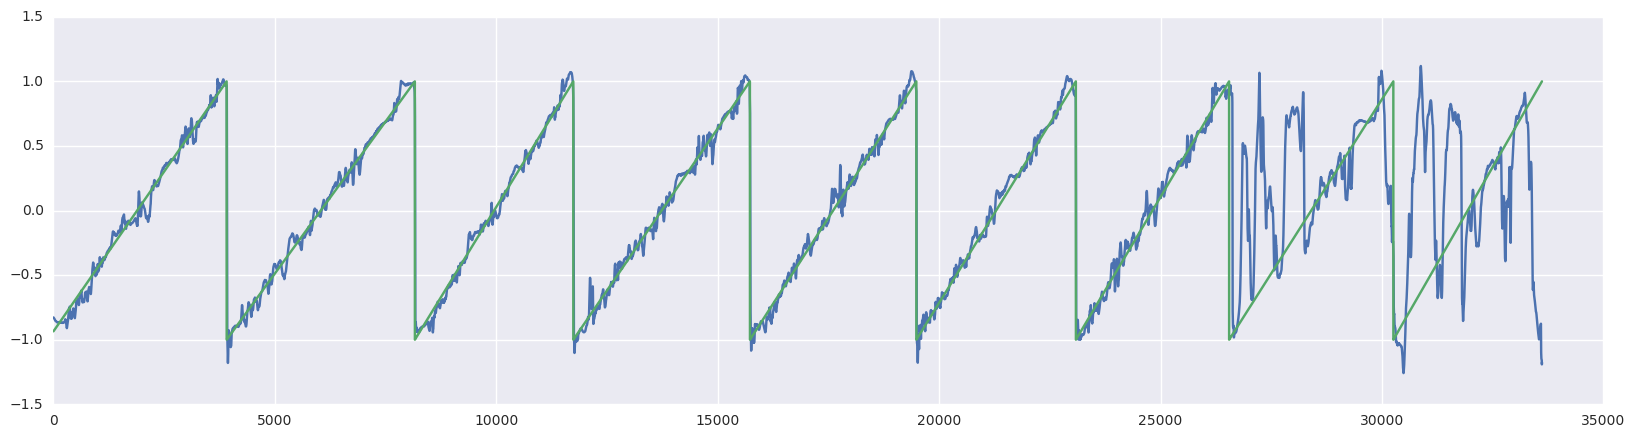

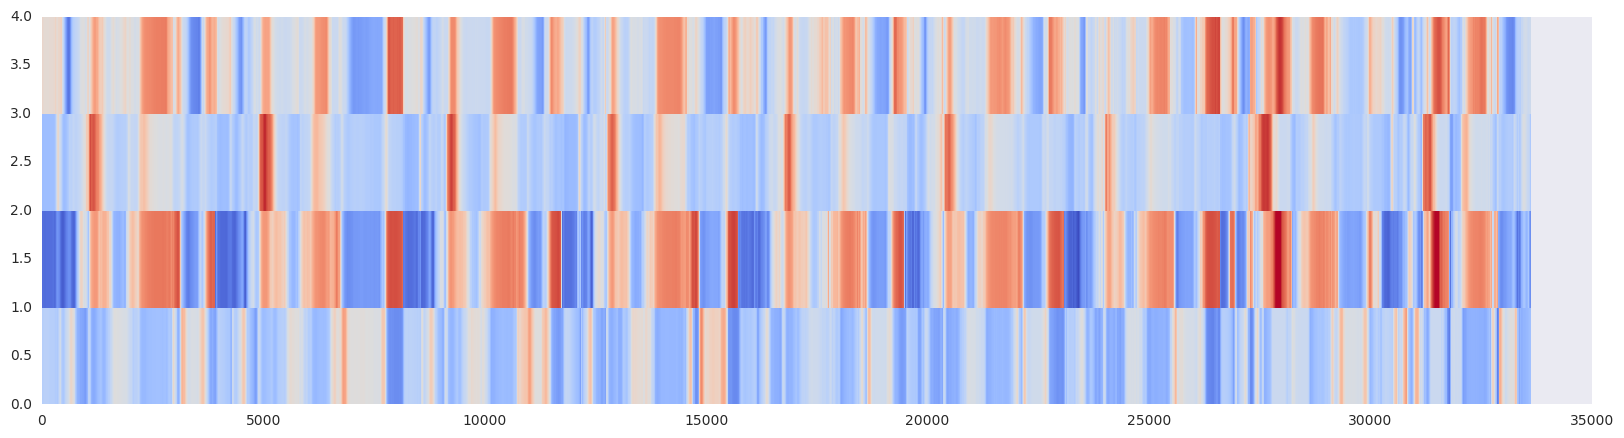

In [113]:
plt.figure(figsize=(20,5))
plt.plot(graph)
plt.figure(figsize=(20,5))
start=0
size=40000
plt.plot(x_pred[start:start+size,:])
plt.plot(y[start:start+size,:])
#plt.plot(x_pred[start:start+size,input_shape-8,1]-x_[start:start+size,0,0])
plt.figure(figsize=(20,5))
plt.pcolor(x_latent[start:start+size,:4].T, cmap=plt.cm.coolwarm_r)

In [107]:
start=0
size=35000
step_ahead=model_configuration.step_ahead
error=(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1])
error_ewma = pd.DataFrame(error).ewm(com=100).std(bias=False)*3
#sigma3=abs(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1]).std()*3
absolute_error=0.2
print(sigma3)
error.shape

0.901066080956


(33608, 1)

(array([[  4.47942992e-11,   7.74943870e-10,   6.84931705e-11, ...,
           3.44103367e-10,   6.65230064e-10,   7.93915983e-06],
        [  2.33133142e-10,   1.11337812e-10,   6.97242283e-11, ...,
           3.79312389e-08,   4.22041464e-08,   8.95846264e-06],
        [  1.33004707e-09,   1.05234376e-09,   6.08525656e-12, ...,
           1.70284442e-07,   1.64028924e-07,   6.90627129e-06],
        ..., 
        [  2.41151483e-10,   7.70173942e-11,   2.57856295e-10, ...,
           4.33678809e-07,   4.45945630e-07,   1.38264544e-05],
        [  1.33004707e-09,   1.05234376e-09,   6.08525656e-12, ...,
           1.70284442e-07,   1.64028924e-07,   6.90627129e-06],
        [  2.33133142e-10,   1.11337812e-10,   6.97242283e-11, ...,
           3.79312389e-08,   4.22041464e-08,   8.95846264e-06]]),
 array([-1.    , -0.9375, -0.875 , -0.8125, -0.75  , -0.6875, -0.625 ,
        -0.5625, -0.5   , -0.4375, -0.375 , -0.3125, -0.25  , -0.1875,
        -0.125 , -0.0625,  0.    ,  0.0625,  0.125

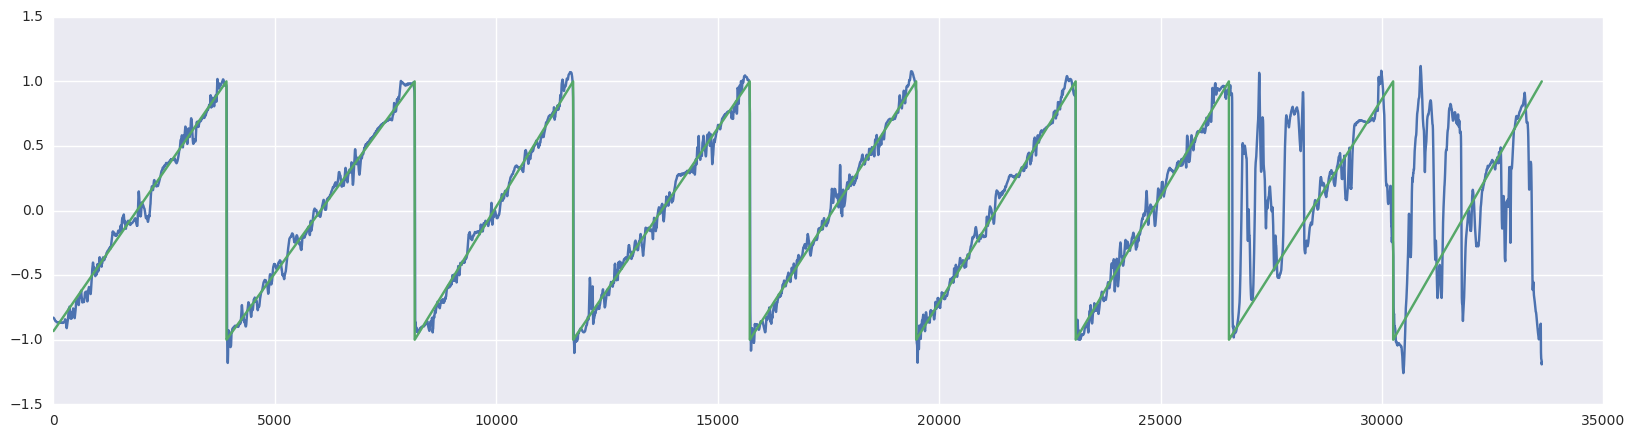

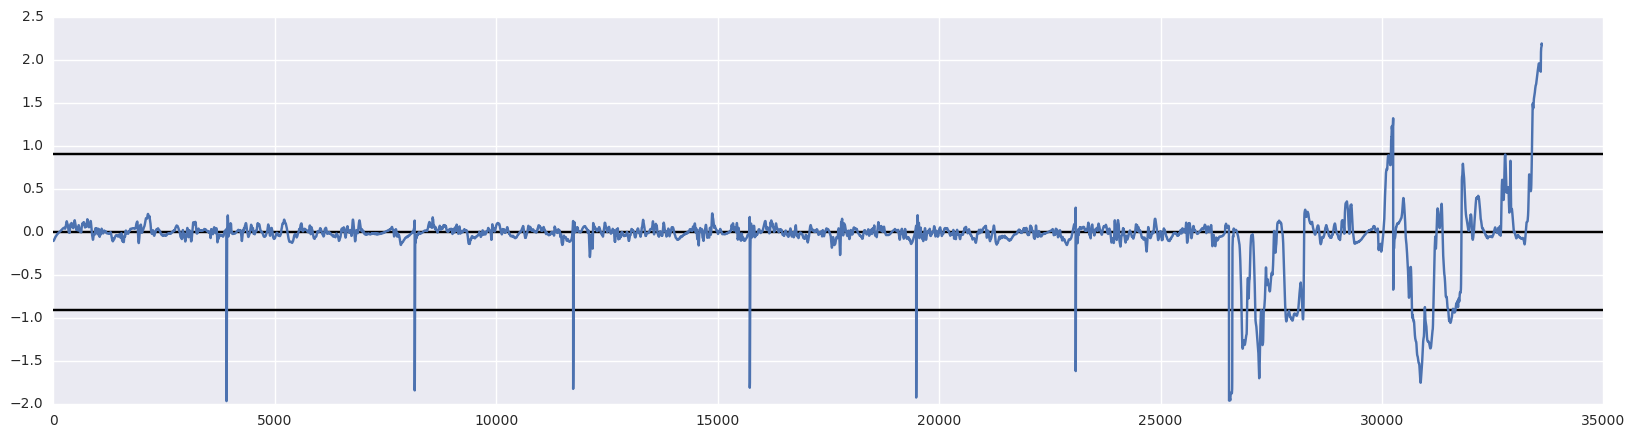

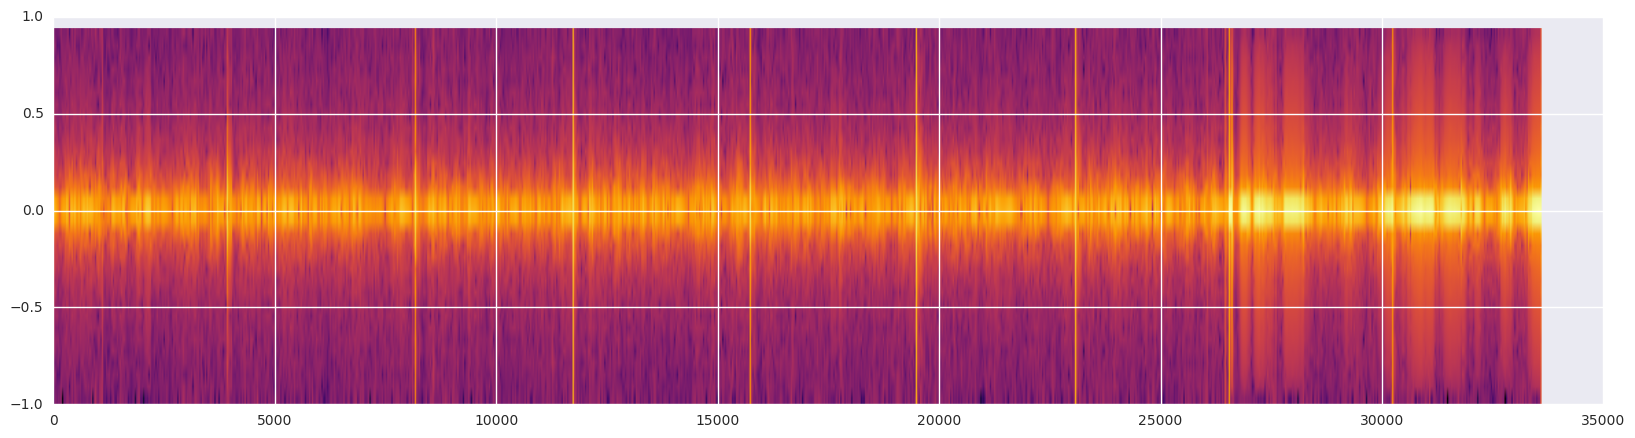

In [109]:
anomalies=np.select([error>=sigma3, error<=-sigma3,error>=-sigma3, error<=sigma3],[1,1,0, 0],0)
anomalies=np.select([error_ewma>=absolute_error, error_ewma<=-absolute_error,error_ewma>=-absolute_error, error_ewma<=absolute_error],[1,1,0, 0],0)
plt.figure(figsize=(20,5))
plt.plot(x_pred[start+step_ahead+1:start+step_ahead+size+1,0])
plt.plot(y[start+step_ahead+1:start+step_ahead+size+1])
plt.figure(figsize=(20,5))
plt.plot(error)
plt.hlines(sigma3 ,0, size)
plt.hlines(-sigma3 ,0, size)
plt.hlines(0 ,0, size)
nfft=32
#plt.plot((error_ewma))
#plt.bar(np.arange(len(anomalies)), anomalies, alpha=.1)
plt.figure(figsize=(20,5))
plt.specgram(error[:,0], NFFT=nfft, noverlap=1, sides='twosided', xextent=(nfft/2.0,len(error)-nfft/2.0),cmap='inferno')